<h2> Multi-agent Reinforcement Learning with Cooperative/Competitive Strategies<h2>


In [1]:
#This code is experimental. Might need revision.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series

        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)

            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise

            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)

            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion

            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None

    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]

    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])

            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()

            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)

            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants

    return best_params, best_error

In [2]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [4]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0. ]
Best error: 0.07478785155345545


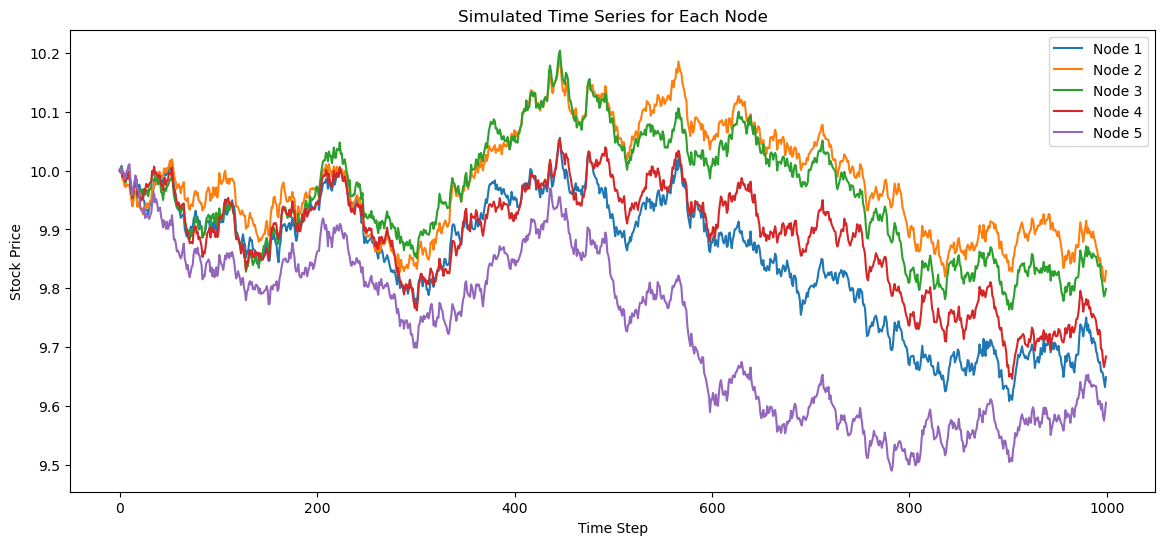

In [5]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

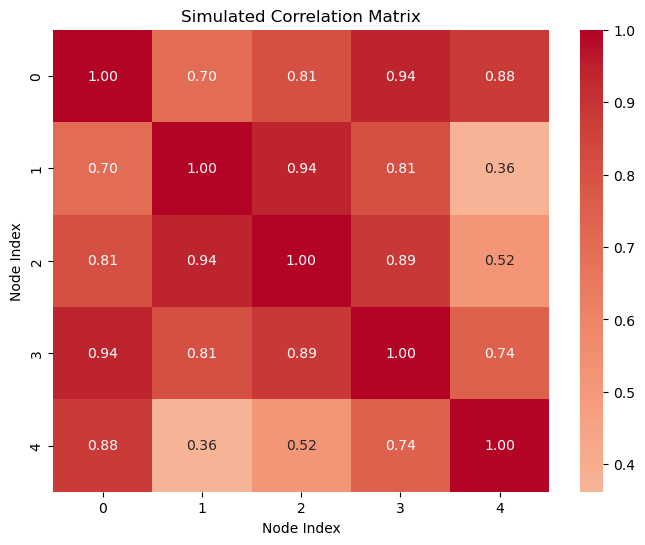

In [6]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [7]:
#Time series of a single node rescaled to match a stock-price

import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 2  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

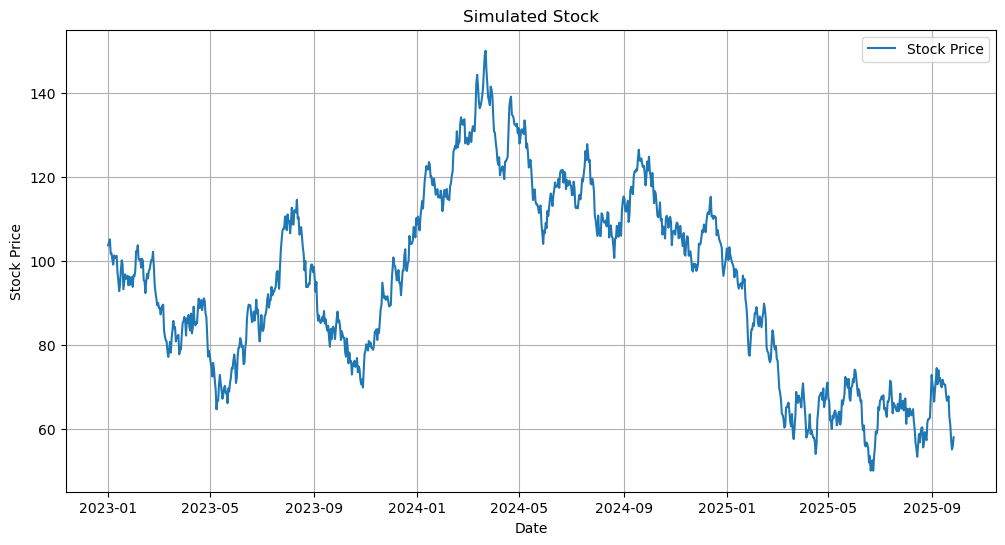

In [8]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [12]:
import numpy as np
import random
import pickle

class TradingEnvironment:
    """Simulates the stock market environment."""
    def __init__(self, stock_prices, fee=0.0001):
        self.stock_prices = stock_prices
        self.fee = fee

    def get_state(self, t):
        """Returns the current stock price as the state."""
        return t  # For simplicity, using the current time index as state

    def take_action(self, action, balance, shares, current_price):
        """Simulates the agent's action and returns updated balance, shares, and reward."""
        if action == 0:  # Hold
            return balance, shares, -0.1  # Small penalty for holding
        elif action == 1:  # Buy
            if balance >= current_price:
                shares += 1
                balance -= current_price * (1 + self.fee)  # Account for commission fee
                return balance, shares, 0  # No immediate profit/loss from buying
            return balance, shares, -1  # Not enough balance
        elif action == 2:  # Sell
            if shares > 0:
                shares -= 1
                sale_amount = current_price * (1 - self.fee)
                balance += sale_amount  # Add sale amount minus fee
                profit = sale_amount - current_price
                return balance, shares, profit  # Reward is profit from sale
            return balance, shares, -1  # No shares to sell

    def cooperative_reward(self, agents):
        """Calculates a reward based on the performance of all agents, promoting cooperation."""
        total_balance = sum(agent.balance for agent in agents)
        total_shares_value = sum(agent.shares * self.stock_prices[-1] for agent in agents)
        coop_reward = total_balance + total_shares_value
        return coop_reward  # Total value can be a cooperative reward


class QLearningAgent:
    """Agent implementing Q-learning."""
    def __init__(self, initial_balance, state_size, action_size, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares = 0
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size, action_size))
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.strategy = "compete"  # Default strategy
        self.allies = []  # List of allies
        self.performance_history = []  # Track performance history for trend analysis

    def choose_action(self, state):
        """Choose an action based on epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.randint(0, 2)  # Explore: Random action
        return np.argmax(self.q_table[state])  # Exploit: Best action

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-values using Q-learning formula."""
        learning_rate = 0.1
        discount_factor = 0.9
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + discount_factor * self.q_table[next_state][best_next_action]
        self.q_table[state][action] += learning_rate * (td_target - self.q_table[state][action])

    def decide_strategy(self, agents, threshold=0.1):
        """Decide whether to cooperate or compete based on performance trends."""
        current_performance = self.balance + self.shares * self.q_table[self.state_size - 1][0]
        average_performance = np.mean([agent.balance + agent.shares * agent.q_table[agent.state_size - 1][0] for agent in agents])
        performance_trend = np.mean(self.performance_history[-5:]) if len(self.performance_history) >= 5 else current_performance

        # Adjust strategy based on performance trend and average
        if current_performance < average_performance * (1 - threshold) and performance_trend < average_performance:
            self.strategy = "cooperate"  # Choose to cooperate if below average and trend is down
            # Form alliances with other agents performing similarly
            for agent in agents:
                if agent != self and agent.strategy == "cooperate":
                    self.form_alliance(agent)
        else:
            self.strategy = "compete"  # Choose to compete otherwise
            # Break alliances if performance improves
            for ally in self.allies[:]:
                if ally.balance + ally.shares * self.q_table[ally.state_size - 1][0] > current_performance:
                    self.break_alliance(ally)

        # Store current performance for trend analysis
        self.performance_history.append(current_performance)

    def form_alliance(self, agent):
        """Form an alliance with another agent."""
        if agent not in self.allies:
            self.allies.append(agent)

    def break_alliance(self, agent):
        """Break alliance with another agent."""
        if agent in self.allies:
            self.allies.remove(agent)

    def reset(self):
        """Reset agent state."""
        self.balance = self.initial_balance
        self.shares = 0
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    # Additional methods...
    
    def save_model(self, filename):
        """Save the Q-table to a file."""
        with open(filename, 'wb') as file:
            pickle.dump(self.q_table, file)

    def load_model(self, filename):
        """Load the Q-table from a file."""
        with open(filename, 'rb') as file:
            self.q_table = pickle.load(file)


class MultiAgentTradingBot:
    def __init__(self, stock_prices, n_agents=2, initial_balance=100000, fee=0.0001):
        self.env = TradingEnvironment(stock_prices, fee=fee)
        # Initialize agents with their respective Q-tables from .npy files
        #for i in range(n_agents):
         #   agent = QLearningAgent(initial_balance, len(stock_prices), 3)  # Create the agent
          #  q_table_file = f'agent_{i}_q_table.npy'  # File name pattern for Q-tables
           # try:
            #    agent.q_table = np.load(q_table_file)  # Load Q-table from .npy file
            #    print(f"Loaded Q-table for agent {i} from {q_table_file}")
            #except FileNotFoundError:
            #    print(f"Q-table file {q_table_file} not found. Initializing agent {i} with empty Q-table.")
            #self.agents.append(agent)  # Add the agent to the list 
        self.agents = [QLearningAgent(initial_balance, len(stock_prices), 3) for _ in range(n_agents)]
        self.stock_prices = stock_prices
        self.initial_balance = initial_balance

    def train(self, epochs):
        for e in range(epochs):
            for agent in self.agents:
                agent.reset()  # Reset balance and shares at the start of each epoch

            for t in range(len(self.stock_prices) - 1):
                for i, agent in enumerate(self.agents):
                    agent.decide_strategy(self.agents)  # Decide strategy based on circumstances
                    state = self.env.get_state(t)

                    if agent.strategy == "cooperate":
                        # Cooperative reward based on total performance of all agents
                        reward = self.env.cooperative_reward(self.agents)  # Cooperative reward
                        agent.update_q_value(state, 0, reward, state)  # Assuming '0' is the action for cooperation
                    else:
                        action = agent.choose_action(state)
                        balance, shares, reward = self.env.take_action(action, agent.balance, agent.shares, self.stock_prices[t])
                        agent.balance, agent.shares = balance, shares  # Update balance and shares
                        agent.update_q_value(state, action, reward, self.env.get_state(t + 1))

                    # Light print statements for monitoring
                    action_names = ["Hold", "Buy", "Sell"]

            # Save Q-tables after each epoch
            for i, agent in enumerate(self.agents):
                agent.save_model(f'agent_{i}_q_table.pkl')

    def evaluate(self):
        """Evaluate the performance of the agents."""
        for i, agent in enumerate(self.agents):
            final_value = agent.balance + agent.shares * self.stock_prices[-1]
            print(f"Agent {i} final value: {final_value:.2f}")

    def load_models(self):
        """Load Q-tables for each agent from files."""
        for i, agent in enumerate(self.agents):
            agent.load_model(f'agent_{i}_q_table.pkl')

In [13]:
# Initialize and train the multi-agent trading bot with an initial balance of $100,000 per agent
bot = MultiAgentTradingBot(stock_prices=df['StockPrice'].values, initial_balance=100000)
bot.train(epochs=1000)  # Train with 1000 epochs

# Evaluate the agents' performance
bot.evaluate()

# Save each agent's Q-table
for i, agent in enumerate(bot.agents):
    agent.save_model(f'agent_{i}_q_table.pkl')

In [14]:
import pickle

num_agents=2

class Agent:
    def __init__(self):
        self.q_table = None  # Initialize Q-table

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.q_table, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            self.q_table = pickle.load(file)

# Load agents
agents = [Agent() for _ in range(num_agents)]  # num_agents is the number of agents you have
for i, agent in enumerate(agents):
    agent.load_model(f'agent_{i}_q_table.pkl')